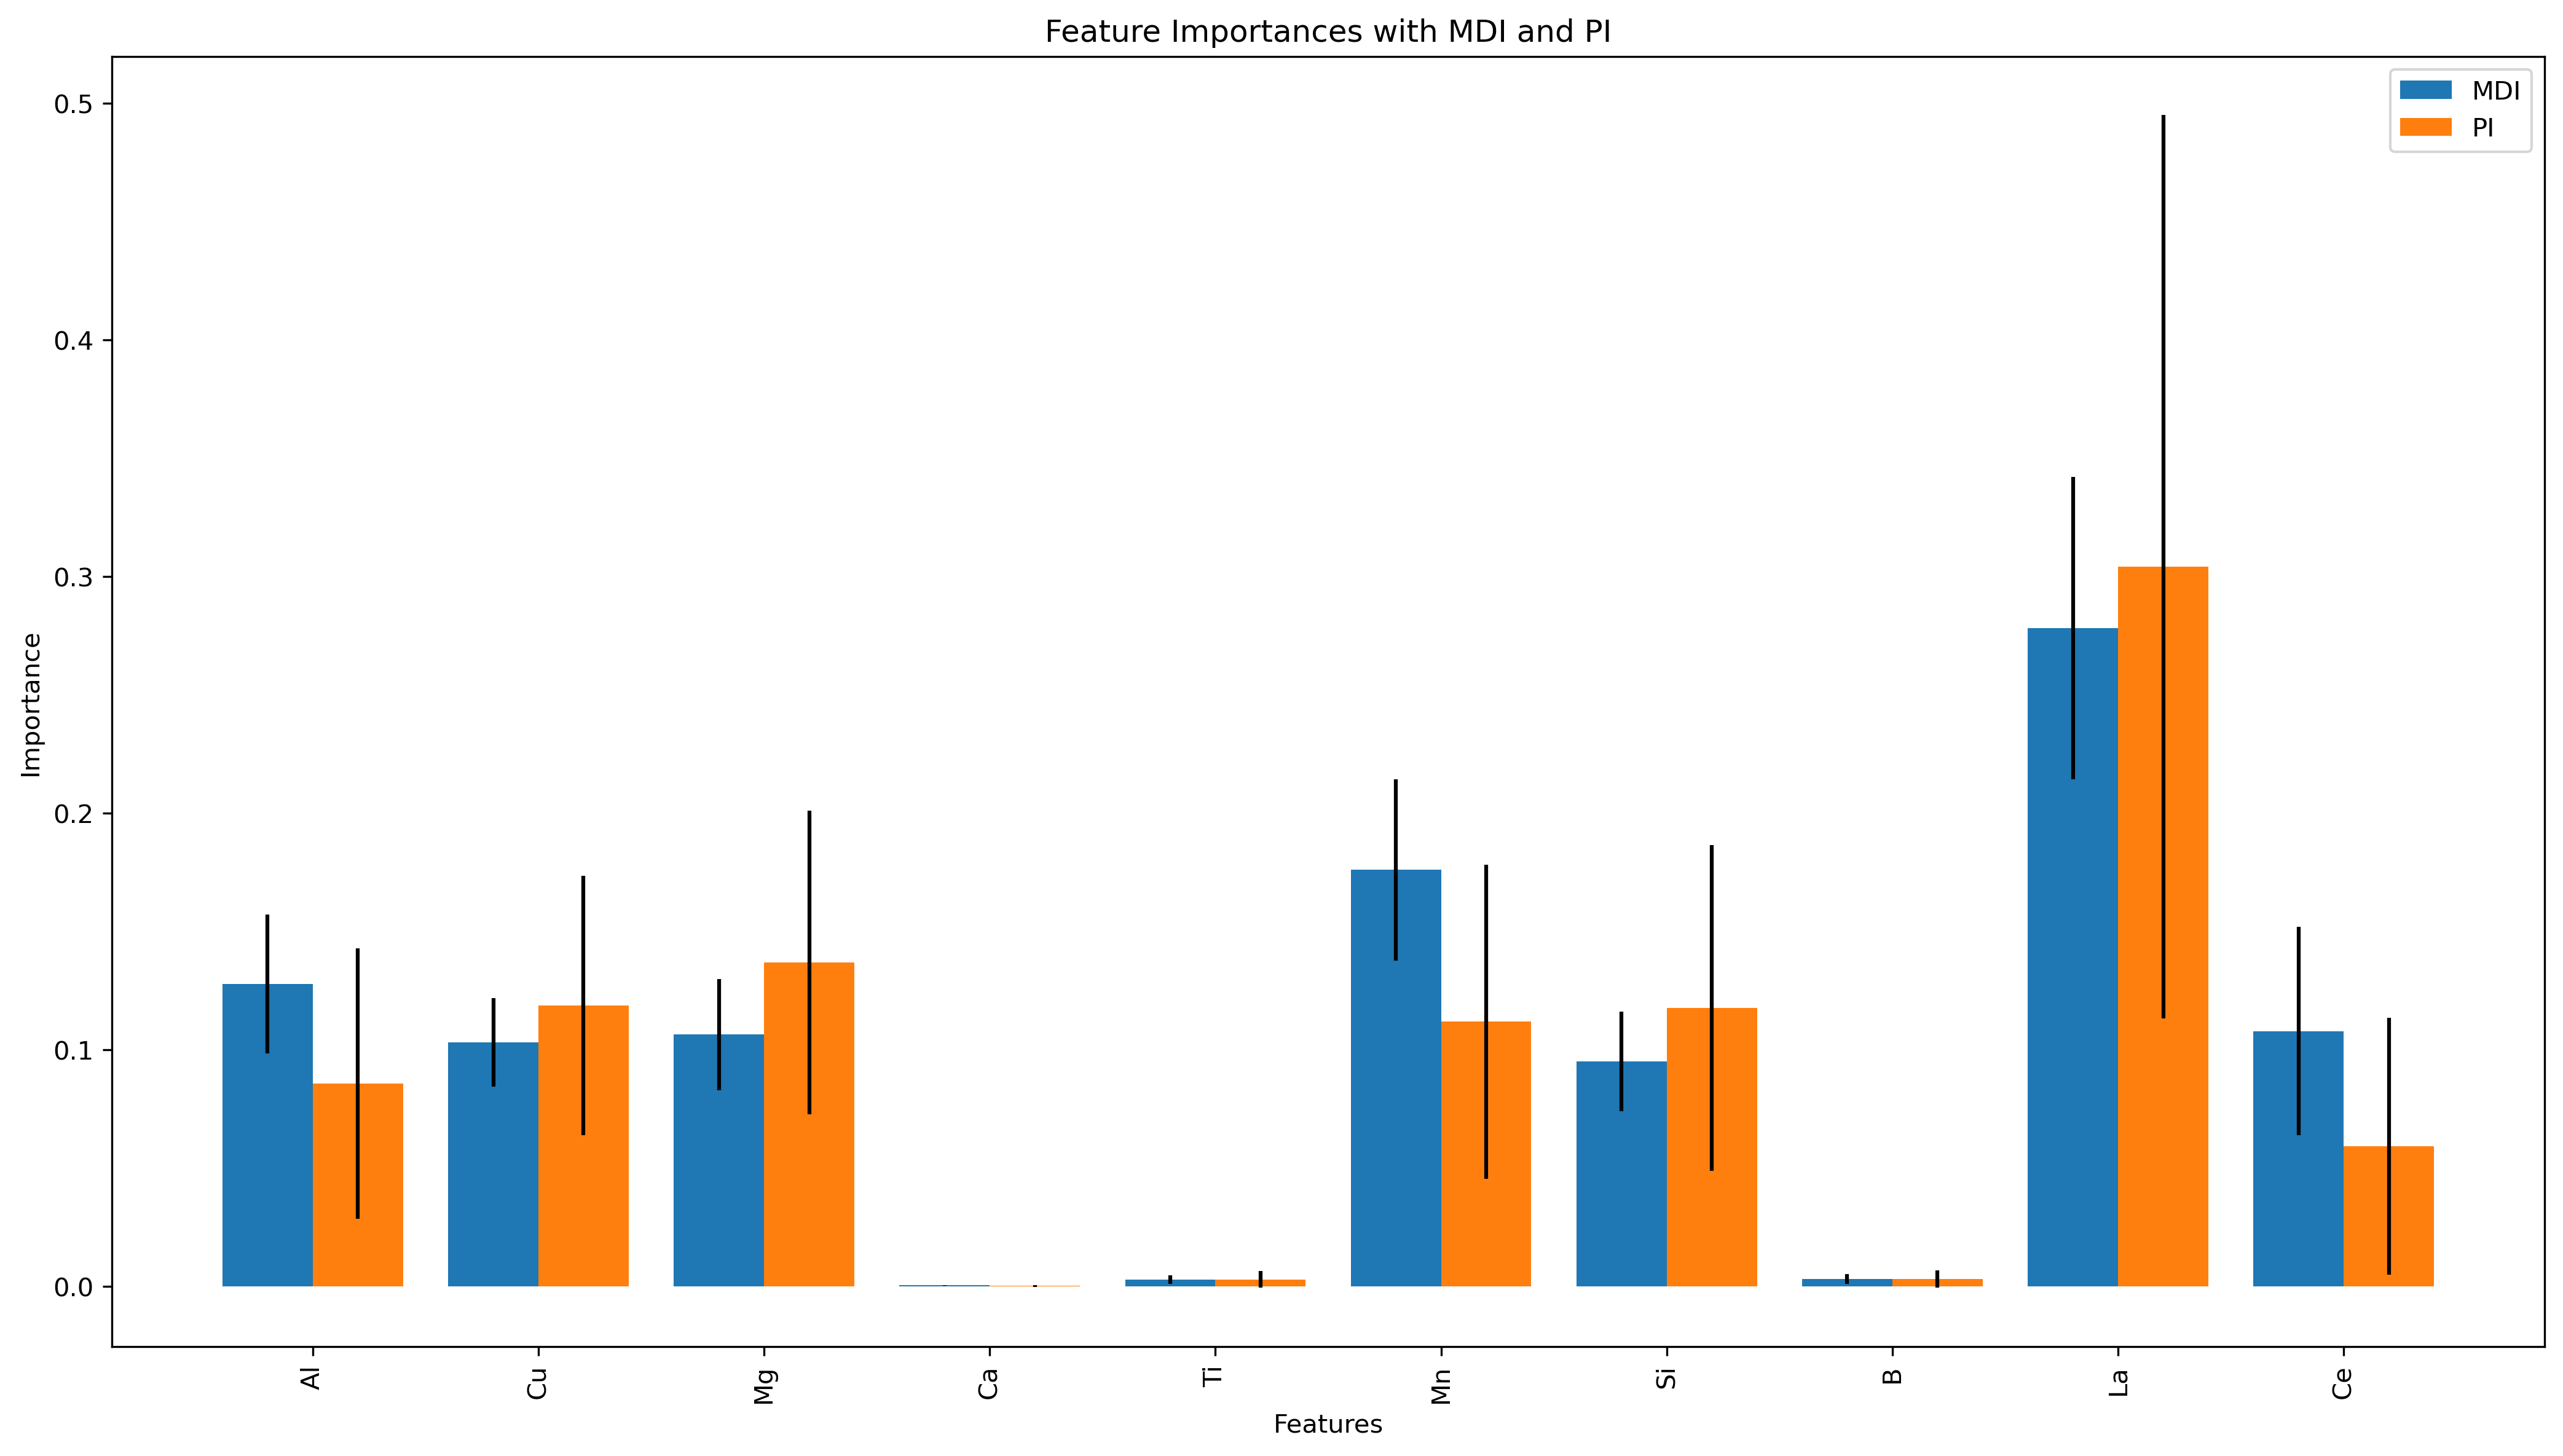

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, LeaveOneOut

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

# 读取数据
data = pd.read_excel('all_EL.xlsx')
data.fillna(0, inplace=True)

X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
column = data.columns.tolist()[1:]

# 初始化存储重要性的数组
mdi_importances = np.zeros((100, len(column)))
pi_importances = np.zeros((100, len(column)))

# 计算100次随机拆分的特征重要性
for seed in range(100):
    # 数据集划分
    X_1 = MinMaxScaler().fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.2, random_state=seed)

    # 训练随机森林模型
    RF = RandomForestRegressor()
    RF.fit(x_train, y_train)

    # 计算MDI特征重要性
    mdi_importances[seed, :] = RF.feature_importances_

    # 计算PI特征重要性
    result = permutation_importance(RF, x_test, y_test, n_repeats=30, random_state=seed)
    pi_importances[seed, :] = result.importances_mean

# 计算平均值和标准差
mdi_mean = mdi_importances.mean(axis=0)
mdi_std = mdi_importances.std(axis=0)
pi_mean = pi_importances.mean(axis=0)
pi_std = pi_importances.std(axis=0)

# 将结果保存到Excel
importance_df = pd.DataFrame({
    'Feature': column,
    'MDI_Mean': mdi_mean,
    'MDI_Std': mdi_std,
    'PI_Mean': pi_mean,
    'PI_Std': pi_std
})

# 创建一个存储每次计算结果的DataFrame
all_importances_df = pd.DataFrame(mdi_importances, columns=[f'MDI_{col}' for col in column])
pi_importances_df = pd.DataFrame(pi_importances, columns=[f'PI_{col}' for col in column])
all_importances_df = pd.concat([all_importances_df, pi_importances_df], axis=1)

# 保存到Excel文件
with pd.ExcelWriter('feature_importances_detailed.xlsx') as writer:
    importance_df.to_excel(writer, sheet_name='Summary', index=False)
    all_importances_df.to_excel(writer, sheet_name='Detailed', index=False)

# 可视化结果
plt.figure(dpi=300, figsize=(14, 8))

# MDI
plt.bar(np.arange(len(column)) - 0.2, mdi_mean, yerr=mdi_std, width=0.4, label='MDI')
# PI
plt.bar(np.arange(len(column)) + 0.2, pi_mean, yerr=pi_std, width=0.4, label='PI')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances with MDI and PI')
plt.xticks(ticks=np.arange(len(column)), labels=column, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
